In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

**2. Đọc file dữ liệu HPG và chia dataset theo tỉ lệ 7:2:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/HPG.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

In [ ]:
df

,Price
0,14831.7
1,15284.1
2,15560.7
3,15409.8
4,15233.9
...,...
1246,21350.0
1247,21200.0
1248,21400.0
1249,21600.0


**3. Dùng model ARIMA để train data**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.2 MB/s eta 0:00:00


In [ ]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = False)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=13685.324, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=13498.429, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=13683.328, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=13398.119, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=13328.696, Time=0.27 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=13304.469, Time=0.58 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=13282.502, Time=0.80 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.61 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=13280.504, Time=0.43 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=13302.457, Time=0.14 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.75 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))


**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[36988.09655454 37043.10581541 37131.72805151 37056.03090143
 37082.35483622 37063.74926867 37053.4310533  37058.41214542
 37065.39286893 37053.35840742 37051.70308729 37047.78314972
 37045.15639587 37043.14201778 37040.9807541  37036.86695387
 37034.01365575 37031.16497141 37028.40114414 37025.5419014
 37022.6439692  37019.58946588 37016.70068799 37013.82216783
 37010.93204938 37008.01403689 37005.09640002 37002.17254169
 36999.26874834 36996.3637095 ]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 16392.243490962468
Testing RMSE: 11854.098295506434
Validation MAPE: 80.14119931984098
Testing MAPE: 46.92211535280273
Validation MAE: 16348.599645863947
Testing MAE: 9581.044040395527


**8. Vẽ biểu đồ**

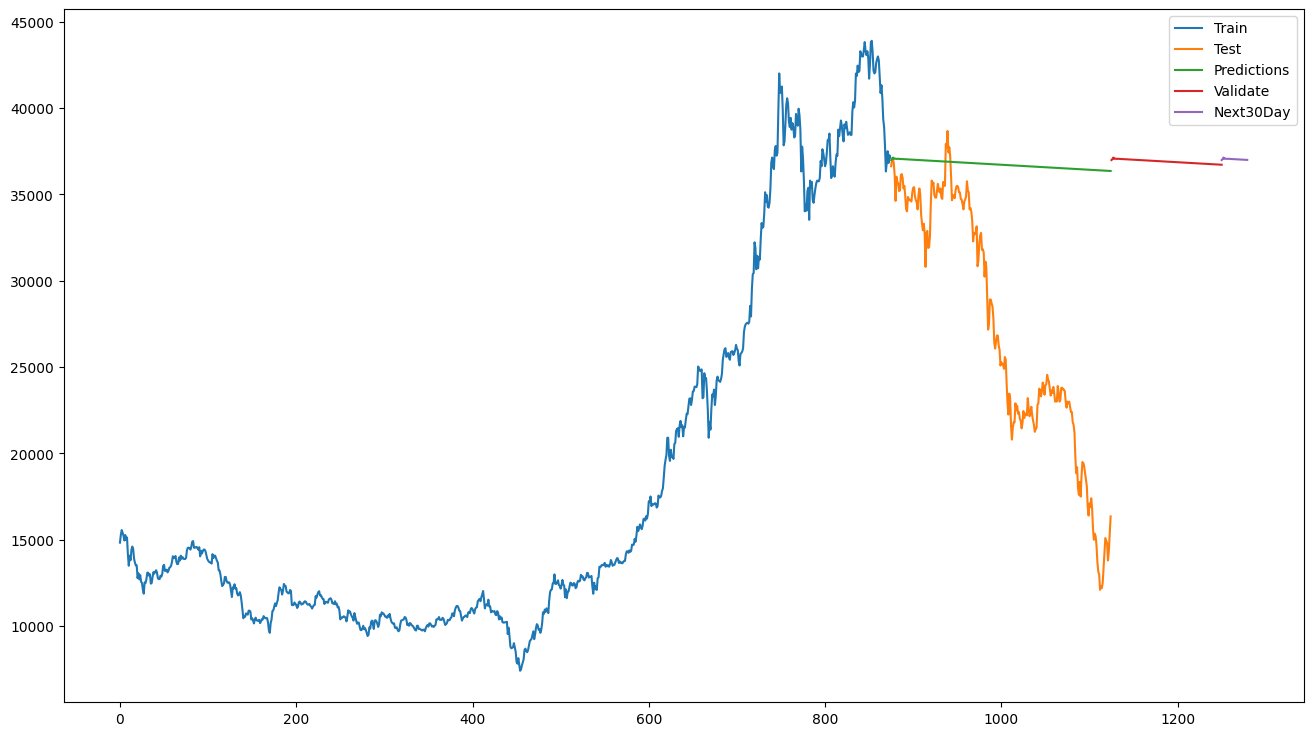

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()